# Train Test Splits, Cross Validation, and Linear Regression

## Introduction

We will be working with a data set based on [housing prices in Ames, Iowa](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). It was compiled for educational use to be a modernized and expanded alternative to the well-known Boston Housing dataset. This version of the data set has had some missing values filled for convenience.

There are an extensive number of features, so they've been described in the table below.

### Predictor

* SalePrice: The property's sale price in dollars. 




In [1]:
from __future__ import print_function
import os
data_path = ['data']

## Question 1

* Import the data using Pandas and examine the shape. There are 79 feature columns plus the predictor, the sale price (`SalePrice`). 
* There are three different types: integers (`int64`), floats (`float64`), and strings (`object`, categoricals). Examine how many there are of each data type. 

In [2]:
import pandas as pd
import os
import numpy as np

# Import the data using the file path
filepath = os.sep.join(data_path + ['Ames_Housing_Sales.csv'])
data = pd.read_csv(filepath, sep=',')

print(data.shape)

(1379, 80)


In [3]:
data.dtypes.value_counts()

object     43
float64    21
int64      16
dtype: int64

## Question 2

As discussed in the lecture, a significant challenge, particularly when dealing with data that have many columns, is ensuring each column gets encoded correctly. 

This is particularly true with data columns that are ordered categoricals (ordinals) vs unordered categoricals. Unordered categoricals should be one-hot encoded, however this can significantly increase the number of features and creates features that are highly correlated with each other.

Determine how many total features would be present, relative to what currently exists, if all string (object) features are one-hot encoded. Recall that the total number of one-hot encoded columns is `n-1`, where `n` is the number of categories.

In [4]:
# Select the object (string) columns
mask = data.dtypes == np.object
print(mask)
categorical_cols = data.columns[mask]
print(categorical_cols)

1stFlrSF        False
2ndFlrSF        False
3SsnPorch       False
Alley            True
BedroomAbvGr    False
                ...  
WoodDeckSF      False
YearBuilt       False
YearRemodAdd    False
YrSold          False
SalePrice       False
Length: 80, dtype: bool
Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood',
       'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       'SaleType', 'Street', 'Utilities'],
      dtype='object')


In [5]:
data[categorical_cols].apply(lambda x: x.nunique()).sort_values(ascending=False)

Neighborhood     25
Exterior2nd      16
Exterior1st      14
SaleType          9
Condition1        9
HouseStyle        8
RoofMatl          8
Condition2        8
Functional        7
BsmtFinType2      7
FireplaceQu       6
Foundation        6
RoofStyle         6
SaleCondition     6
BsmtFinType1      6
Heating           6
GarageType        6
BsmtExposure      5
Electrical        5
Fence             5
GarageCond        5
GarageQual        5
BsmtQual          5
LotConfig         5
MSZoning          5
MiscFeature       5
BldgType          5
HeatingQC         5
KitchenQual       4
LandContour       4
BsmtCond          4
LotShape          4
MasVnrType        4
ExterQual         4
ExterCond         4
PoolQC            4
Alley             3
GarageFinish      3
LandSlope         3
PavedDrive        3
CentralAir        2
Street            2
Utilities         2
dtype: int64

In [6]:
# Determine how many extra columns would be created
num_ohc_cols = (data[categorical_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))


# No need to encode if there is only one value
small_num_ohc_cols = num_ohc_cols.loc[num_ohc_cols>1]

# Number of one-hot columns is one less than the number of categories
small_num_ohc_cols -= 1

# This is 215 columns, assuming the original ones are dropped. 
# This is quite a few extra columns!
small_num_ohc_cols.sum()

215

## Question 3

Let's create a new data set where all of the above categorical features will be one-hot encoded. We can fit this data and see how it affects the results.

* Used the dataframe `.copy()` method to create a completely separate copy of the dataframe for one-hot encoding
* On this new dataframe, one-hot encode each of the appropriate columns and add it back to the dataframe. Be sure to drop the original column.
* For the data that are not one-hot encoded, drop the columns that are string categoricals.

For the first step, numerically encoding the string categoricals, either Scikit-learn;s `LabelEncoder` or `DictVectorizer` can be used. However, the former is probably easier since it doesn't require specifying a numerical value for each category, and we are going to one-hot encode all of the numerical values anyway. (Can you think of a time when `DictVectorizer` might be preferred?)

In [9]:
#import warnings
#warnings.filterwarnings('ignore', module='sklearn')

In [10]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Copy of the data
data_ohc = data.copy()

# The encoders
le = LabelEncoder()
ohc = OneHotEncoder()

for col in num_ohc_cols.index:
    
    # Integer encode the string categories
    dat = le.fit_transform(data_ohc[col]).astype(np.int)
    
    # Remove the original column from the dataframe
    data_ohc = data_ohc.drop(col, axis=1)

    # One hot encode the data--this returns a sparse array
    new_dat = ohc.fit_transform(dat.reshape(-1,1))

    # Create unique column names
    n_cols = new_dat.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]

    # Create the new dataframe
    new_df = pd.DataFrame(new_dat.toarray(), 
                          index=data_ohc.index, 
                          columns=col_names)

    # Append the new data to the dataframe
    data_ohc = pd.concat([data_ohc, new_df], axis=1)

In [11]:
# Column difference is as calculated above
data_ohc.shape[1] - data.shape[1]

215

In [12]:
print(data.shape[1])

# Remove the string columns from the dataframe
data = data.drop(num_ohc_cols.index, axis=1)

print(data.shape[1])

80
37


## Question 4

* Create train and test splits of both data sets. To ensure the data gets split the same way, use the same `random_state` in each of the two splits.
* For each data set, fit a basic linear regression model on the training data. 
* Calculate the mean squared error on both the train and test sets for the respective models. Which model produces smaller error on the test data and why?

In [13]:
from sklearn.model_selection import train_test_split

y_col = 'SalePrice'

# Split the data that is not one-hot encoded
feature_cols = [x for x in data.columns if x != y_col]
X_data = data[feature_cols]
y_data = data[y_col]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.3, random_state=42)
# Split the data that is one-hot encoded
feature_cols = [x for x in data_ohc.columns if x != y_col]
X_data_ohc = data_ohc[feature_cols]
y_data_ohc = data_ohc[y_col]

X_train_ohc, X_test_ohc, y_train_ohc, y_test_ohc = train_test_split(X_data_ohc, y_data_ohc, 
                                                    test_size=0.3, random_state=42)

In [14]:
# Compare the indices to ensure they are identical
(X_train_ohc.index == X_train.index).all()

True

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

LR = LinearRegression()

# Storage for error values
error_df = list()

# Data that have not been one-hot encoded
LR = LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

error_df.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred),
                           'test' : mean_squared_error(y_test,  y_test_pred)},
                           name='no enc'))

# Data that have been one-hot encoded
LR = LR.fit(X_train_ohc, y_train_ohc)
y_train_ohc_pred = LR.predict(X_train_ohc)
y_test_ohc_pred = LR.predict(X_test_ohc)

error_df.append(pd.Series({'train': mean_squared_error(y_train_ohc, y_train_ohc_pred),
                           'test' : mean_squared_error(y_test_ohc,  y_test_ohc_pred)},
                          name='one-hot enc'))

# Assemble the results
error_df = pd.concat(error_df, axis=1)
error_df


'\n# Assemble the results\nerror_df = pd.concat(error_df, axis=1)\nerror_df\n'

In [26]:
LR1= LR.fit(X_data, y_data)

y_pred = LR1.predict(X_data)

In [27]:
# Function to calculate the % of values that were correctly predicted

def accuracy(real, predict):
    return sum(real == predict) / float(real.shape[0])

In [30]:
print(accuracy(y_data, y_pred))

0.0


Note that the error values on the one-hot encoded data are very different for the train and test data. In particular, the errors on the test data are much higher. Based on the lecture, this is because the one-hot encoded model is overfitting the data. We will learn how to deal with issues like this in the next lesson.

## Question 5

For each of the data sets (one-hot encoded and not encoded):

* Scale the all the non-hot encoded values using one of the following: `StandardScaler`, `MinMaxScaler`, `MaxAbsScaler`.
* Compare the error calculated on the test sets

Be sure to calculate the skew (to decide if a transformation should be done) and fit the scaler on *ONLY* the training data, but then apply it to both the train and test data identically.

In [16]:
# Mute the setting wtih a copy warnings
pd.options.mode.chained_assignment = None

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler


scalers = {'standard': StandardScaler(),
           'minmax': MinMaxScaler(),
           'maxabs': MaxAbsScaler()}

training_test_sets = {
    'not_encoded': (X_train, y_train, X_test, y_test),
    'one_hot_encoded': (X_train_ohc, y_train_ohc, X_test_ohc, y_test_ohc)}


# Get the list of float columns, and the float data
# so that we don't scale something we already scaled. 
# We're supposed to scale the original data each time
mask = X_train.dtypes == np.float
float_columns = X_train.columns[mask]

# initialize model
LR = LinearRegression()

# iterate over all possible combinations and get the errors
errors = {}
for encoding_label, (_X_train, _y_train, _X_test, _y_test) in training_test_sets.items():
    for scaler_label, scaler in scalers.items():
        trainingset = _X_train.copy()  # copy because we dont want to scale this more than once.
        testset = _X_test.copy()
        trainingset[float_columns] = scaler.fit_transform(trainingset[float_columns])
        testset[float_columns] = scaler.transform(testset[float_columns])
        LR.fit(trainingset, _y_train)
        predictions = LR.predict(testset)
        key = encoding_label + ' - ' + scaler_label + 'scaling'
        errors[key] = mean_squared_error(_y_test, predictions)

errors = pd.Series(errors)
print(errors.to_string())
print('-' * 80)
for key, error_val in errors.items():
    print(key, error_val)

not_encoded - standardscaling        1.372182e+09
not_encoded - minmaxscaling          1.372213e+09
not_encoded - maxabsscaling          1.372261e+09
one_hot_encoded - standardscaling    8.065328e+09
one_hot_encoded - minmaxscaling      8.065328e+09
one_hot_encoded - maxabsscaling      8.065328e+09
--------------------------------------------------------------------------------
not_encoded - standardscaling 1372182358.934513
not_encoded - minmaxscaling 1372213374.928995
not_encoded - maxabsscaling 1372260724.0741587
one_hot_encoded - standardscaling 8065327607.247206
one_hot_encoded - minmaxscaling 8065327607.2559
one_hot_encoded - maxabsscaling 8065327607.216928


## Question 6

Plot predictions vs actual for one of the models.

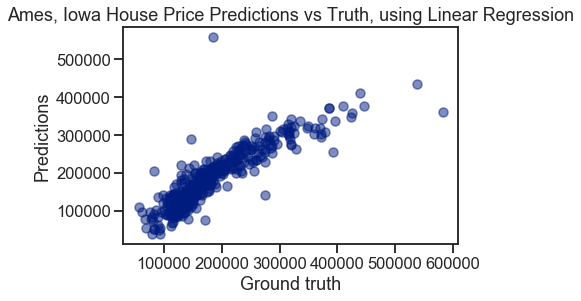

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test, y_test_pred, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Ames, Iowa House Price Predictions vs Truth, using Linear Regression');

In [33]:
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,SalePrice
0,856.0,854.0,0.0,None,3,1Fam,TA,No,706.0,0.0,...,0.0,Pave,8,856.0,AllPub,0.0,2003,2003,2008,208500.0
1,1262.0,0.0,0.0,None,3,1Fam,TA,Gd,978.0,0.0,...,0.0,Pave,6,1262.0,AllPub,298.0,1976,1976,2007,181500.0
2,920.0,866.0,0.0,None,3,1Fam,TA,Mn,486.0,0.0,...,0.0,Pave,6,920.0,AllPub,0.0,2001,2002,2008,223500.0
3,961.0,756.0,0.0,None,3,1Fam,Gd,No,216.0,0.0,...,0.0,Pave,7,756.0,AllPub,0.0,1915,1970,2006,140000.0
4,1145.0,1053.0,0.0,None,4,1Fam,TA,Av,655.0,0.0,...,0.0,Pave,9,1145.0,AllPub,192.0,2000,2000,2008,250000.0


In [34]:
# Import and display first five rows of advertising dataset
advert = pd.read_csv('advertising.csv')
advert.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [41]:
import statsmodels.formula.api as smf

# Initialise and fit linear regression model using `statsmodels`
model = smf.ols('sales~TV', data=advert)
model = model.fit()

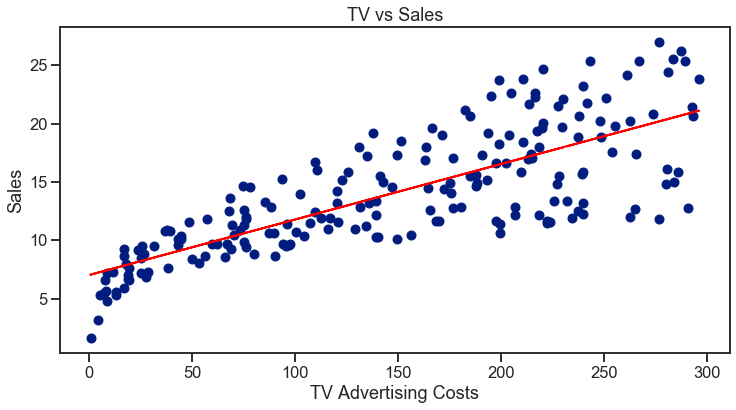

In [43]:
# Predict values
sales_pred = model.predict()

# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(advert['TV'], advert['sales'], 'o')           # scatter plot showing actual data
plt.plot(advert['TV'], sales_pred, 'r', linewidth=2)   # regression line
plt.xlabel('TV Advertising Costs')
plt.ylabel('Sales')
plt.title('TV vs Sales')

plt.show()

In [44]:
new_X = 400
model.predict({"TV": new_X})

0    26.04725
dtype: float64

In [46]:
from sklearn.linear_model import LinearRegression

# Build linear regression model using TV and Radio as predictors
# Split data into predictors X and output Y
predictors = ['TV', 'radio']
X = advert[predictors]
y = advert['sales']

# Initialise and fit model
lm = LinearRegression()
model = lm.fit(X, y)

In [47]:
print(f'alpha = {model.intercept_}')
print(f'betas = {model.coef_}')

alpha = 2.921099912405138
betas = [0.04575482 0.18799423]


In [48]:
model.predict(X)

array([20.55546463, 12.34536229, 12.33701773, 17.61711596, 13.22390813,
       12.51208449, 11.71821241, 12.10551553,  3.7093792 , 12.55169696,
        7.0358597 , 17.25652015, 10.60866187,  8.81095051, 18.44466773,
       20.82891539, 12.90386507, 23.24107626,  9.94121476, 14.15384619,
       18.12139161, 14.74206357,  6.51417168, 16.54402663,  8.14035215,
       15.6080206 , 14.96769383, 17.0463346 , 19.39954145,  9.15929748,
       21.64292187, 11.35791808,  7.65045928, 18.83346334,  7.56302763,
       16.99280099, 23.36720719, 15.6258994 ,  9.91257829, 20.4405801 ,
       16.37872122, 17.29870935, 21.5621537 , 13.96692266,  8.9009974 ,
       15.16263814,  8.88644967, 21.69944046, 16.28690268,  8.18162949,
       12.64569407,  9.31962792, 20.66180115, 19.96126242, 20.35512357,
       21.30864743,  8.53774783, 12.76239488, 21.89072858, 18.10746914,
        5.74497097, 22.90418658, 16.78413768, 13.18474853, 16.96570907,
        7.82652846,  8.98703456, 12.02066194, 18.95313425, 21.09

In [49]:
new_X = [[300, 200]]
print(model.predict(new_X))

[54.24638977]
